In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain
from copy import deepcopy
from scipy import signal, ndimage
from PIL import Image
%matplotlib inline

# Question 1 - Convolution, Fourier transform and linear systems

## Section A - DFT “Free Willy”

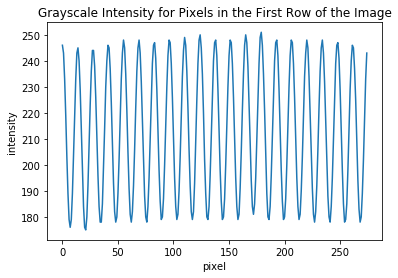

In [2]:
plt.title('Grayscale Intensity for Pixels in the First Row of the Image')
plt.xlabel('pixel')
plt.ylabel('intensity')
_=plt.plot(cv2.imread('cat_bars.png',0)[0])

From the plot of the first row of the image we can see that there are 20 signal repetitions of the stripes, i.e. frequency=20.  
So, that is the frequency that we want to remove.

C:\Users\galel\anaconda3\lib\site-packages\ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


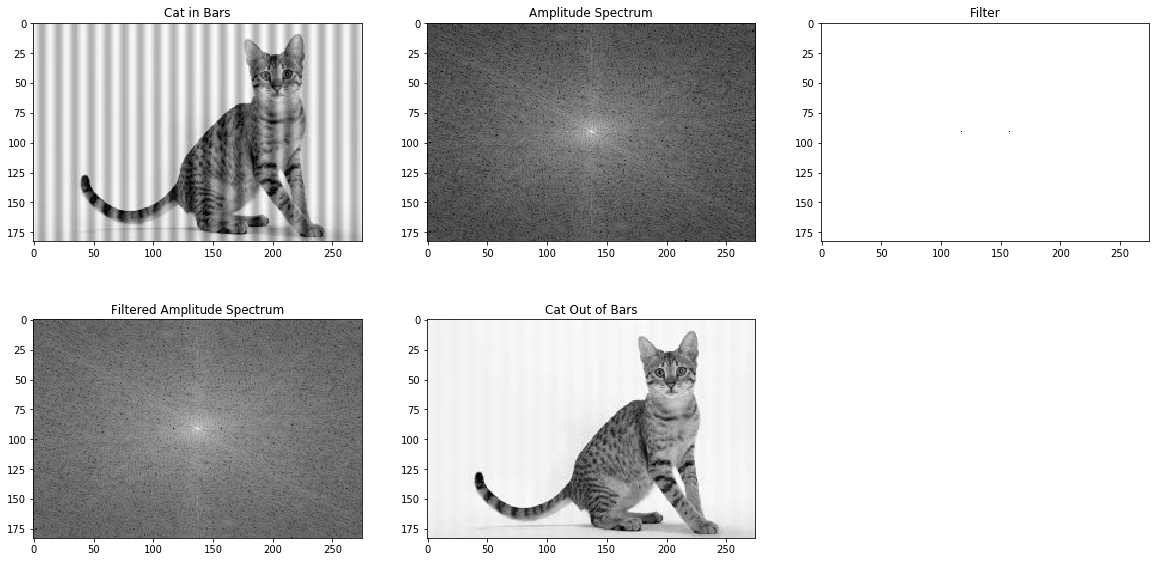

In [3]:
cat_bars = cv2.imread('cat_bars.png',0) # Reads the original grayscale image

#======= Replace with code to get the cat out of the bars
img_fft = np.fft.fft2(cat_bars)
fshift = np.fft.fftshift(img_fft)
amplitude = np.log(np.abs(fshift)+1) # Replace with code to get the image’s amplitude spectrum

remove_freq = 20
rows, cols = cat_bars.shape
crow,ccol = rows//2 , cols//2
filter = np.ones(cat_bars.shape)
filter[crow,ccol-remove_freq] = 0
filter[crow,ccol+remove_freq] = 0

amplitude_filtered = np.log(np.abs(fshift*filter)+1) # The amplitude spectrum after the filtering.

cat_out_of_bars = np.fft.ifft2(np.fft.ifftshift(fshift*filter)).astype('float') # Replace with code to get the cat out of bars (the filtered image)
#========

# Showing the 5 plots requested in this section
fig, axes = plt.subplots(2,3, figsize=(20, 10))
fig.delaxes(axes[1,2])
for img, ax, title in zip([cat_bars, amplitude, filter, amplitude_filtered, cat_out_of_bars],
                          chain.from_iterable(axes), 
                          ["Cat in Bars", "Amplitude Spectrum", "Filter", "Filtered Amplitude Spectrum", "Cat Out of Bars"]):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)

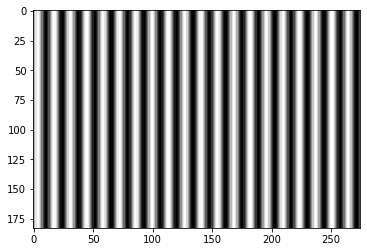

In [4]:
##################
sineImg = np.zeros(cat_bars.shape)
f_x = 20/ cat_bars.shape[1]
x = np.array(range(0,cat_bars.shape[1]))
for cols in range(0,cat_bars.shape[1]):
    sineImg[:,cols] = 0.1 * np.sin(2 * np.pi * f_x * x[cols])

plt.imshow(sineImg, cmap='gray')
plt.show()
#################


# Question 2 - Edge detection

## Section B

In [5]:
def zero_crossing(LoG, a, b):
    """
    This function gets as input the LoG and calculates the zero crossings. 
    The output is a binary matrix with 1 in all the zero crossing pixels
    and 0 otherwise.
    """
    kernel = np.array([
        [1, 1, 1],
        [1, 0, 1],
        [1, 1, 1],
    ])
    has_8env_larger_than_a = signal.convolve2d(LoG>a, kernel, mode='same')>0
    has_8env_smaller_than_b = signal.convolve2d(LoG<b, kernel, mode='same')>0
    
    return ((LoG<b)*has_8env_larger_than_a + (LoG>a)*has_8env_smaller_than_b).astype('int')

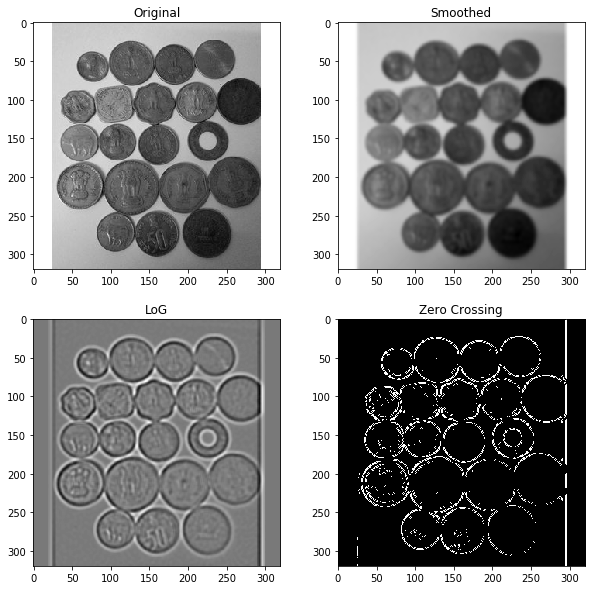

In [6]:
# Reads the original image in grayscale, and sets the image range to be 0-1 (instead of 0-255)
coins = cv2.imread('coins.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float) / 255 #'coins': The original image in grayscale.

## Implementation of LoG as shown in tutorial #6
laplacian_kernel = np.array([
    [0, -1,  0],
    [-1, 4, -1],
    [0, -1,  0],
])


# 'smoothed': The smoothed image (i.e., the image after applying the Gaussian smoothing).
smoothed = cv2.GaussianBlur(coins, (9, 9) ,2) # You may change the 'ksize' parameter (7,7) and the sigma parameter 0.
LoG = cv2.filter2D(smoothed, ddepth=cv2.CV_64F, kernel=laplacian_kernel).astype(np.float) #'LoG': The image after applying LoG.

# 'zc': The image of the detected edges after applying zero-crossing. 
zc = zero_crossing(LoG,
                   a = 0.0035,
                   b = -0.006) # You may change the parameters a, b to get the best result


# Showing the 4 plots requested in this section
_, axes = plt.subplots(2, 2, figsize=(10, 10))
for ax, img ,title in zip(axes.flatten(),
                          [coins, smoothed, LoG, zc],
                          ["Original", "Smoothed", "LoG", "Zero Crossing"]):
    ax.imshow(img,
              cmap='gray')
    ax.set_title(title)


## Section C

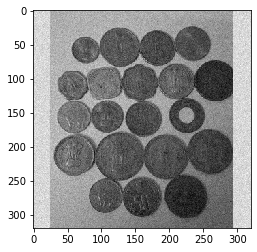

In [7]:
# coins' image with added Gaussian noise
noisy_coins = coins + np.random.standard_normal(coins.shape) * 0.05

plt.imshow(noisy_coins, cmap='gray')
plt.show()

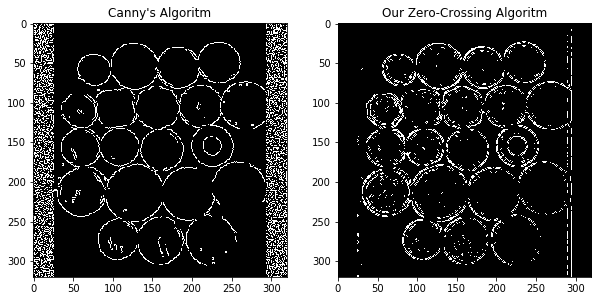

In [8]:
# OpenCV expects image with value range of 0 - 255
# Therefore, for cv2 functions (such as cv2.Canny) use the following variable instead of 'noisy_coins'
noisy_coins_uint8 = (noisy_coins * 255).astype(np.uint8) 

#=============
# Find edges in the noisy image by using
# cv2.Canny and your method from section A. Plot the results side by side.
canny_t1 = 200
canny_t2 = 400
canny_edges = cv2.Canny(noisy_coins_uint8, canny_t1, canny_t2)
#Ours
a = 0.00035#0.000035
b = -0.009
smoothed = cv2.GaussianBlur(noisy_coins, (9, 9) ,2)
LoG = cv2.filter2D(smoothed, ddepth=cv2.CV_64F, kernel=laplacian_kernel).astype(np.float) 
our_edges = zero_crossing(LoG, a, b)
#plots:
_, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(canny_edges, cmap='gray')
axes[0].set_title('Canny\'s Algoritm')
axes[1].imshow(our_edges, cmap='gray')
_=axes[1].set_title('Our Zero-Crossing Algoritm')